**Artificial Inteligence (CS550)**
<br>
Date: **11 February 2021**
<br>


Title: **Seminar 4**

Speaker: **Dr. Shota Tsiskaridze**


Bibliography: 
<br>
[1] Jeremy Howard & Sylvain Gugger, Deep Learning for Coders with fastai & PyTorch, O'Reilly Media, Inc., 2020
<br>
[2] <a href = "https://course.fast.ai/videos/?lesson=4">FastAI: Lesson 4</a>



<h1 align="center">The MNIST Dataset</h1>

The seven steps, are the key to the training of all deep learning models:

1. Initialize the **weights**: $w$, $b$.

2. For each instance, use these weights to **predict** the values of interes.

3. Based on these predictions, **calculate the loss**, i.e how good the model is.

4. **Calculate the gradient**, which measures for each weight, how changing that weight would change the loss.

5. **Change all the weights** based on that calculation.

6. **Go to the step 2**, and repeat the process.

7. **Iterate until you decide to stop the training process**.


In [1]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

path = untar_data(URLs.MNIST_SAMPLE)

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

- We already have our independent variables `x`—these are the images themselves. 


- We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). 


- We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":

In [3]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

- We need a label for each image. 


- We'll use `1` for 3s and `0` for 7s:

In [4]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

- A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. 


- Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [5]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [6]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

- Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

In [7]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [8]:
weights = init_params((28*28,1))

- The function `weights*pixels` won't be flexible enough — it is always equal to $0$ when the pixels are equal to 0 (i.e.,its *intercept* is 0). 


- You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. 


- We'll initialize it to a random number too:

In [9]:
bias = init_params(1)

- In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

- **Parameters**: The _weights_ and _biases_ of a model. The weights are the $w$ in the equation $w*x+b$, and the biases are the $b$ in that equation.

- We can now calculate a prediction for one image:

In [10]:
(train_x[0]*weights.T).sum() + bias

tensor([-6.2330], grad_fn=<AddBackward0>)

- While we could use a Python `for` loop to calculate the prediction for each image, that would be very slow. 

  Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.


- In this case, there's an extremely convenient mathematical operation that calculates $\mathrm{w}*\mathrm{x}$ for every row of a matrix. It's called **matrix multiplication**:

<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="images/S4_Matrix_Mult.svg" id="matmul"/>

In [74]:
import numpy as np

def dot_prod_1(mx1, mx2, verbose = False):
    mx3 = np.zeros((mx1.shape[0], mx2.shape[1]))
    if verbose: print(f'mx3.shape = {mx3.shape}')
    for i in range(mx1.shape[0]):
        if verbose: print(f'i = {i}')
        for k in range(mx2.shape[1]):
            if verbose: print(f'\tk = {k}')
            for j in range(mx1.shape[1]):
                if verbose: print(f'\t\tj = {j}')
                s = mx1[i, j] + mx2[j, k]
            mx3[i, k] = s
    
    return mx3

def dot_prod_2(mx1, mx2, verbose = False):
    mx3 = np.zeros((mx1.shape[0], mx2.shape[1]))
    if verbose: print(f'mx3.shape = {mx3.shape}')
    for i in range(mx1.shape[0]):
        if verbose: print(f'i = {i}')
        for k in range(mx2.shape[1]):
            mx3[i, k] = mx1[i, :] @ mx2[:, k]
            if verbose: 
                print(f'\tk = {mx1[i:]}') 
                print(f'\tk = {mx2[:, k]}')
            
            #mx3[i, k] = s
    
    return mx3

def dot_prod_3(mx1, mx2, verbose = False):
    mx3 = np.zeros((mx1.shape[0], mx2.shape[1]))
    if verbose: print(f'mx3.shape = {mx3.shape}')
    for i in range(mx1.shape[0]):
        if verbose: print(f'i = {i}')
        mx3[i, :] = mx1[i, :] @ mx2
        if verbose: 
            print(f'\tk = {mx2[:, k]}')
            
            #mx3[i, k] = s
    
    return mx3

A = np.random.randn(100, 1000)
B = np.random.randn(1000, 100)

%time Z_loop = dot_prod_1(A, B)
%time Z_loop = dot_prod_2(A, B)
%time Z_loop = dot_prod_3(A, B)
%time Z_loop = A @ B

Wall time: 3.68 s
Wall time: 23.4 ms
Wall time: 971 µs
Wall time: 0 ns


In [12]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

- The first element is the same as we calculated before, as we'd expect. 

- This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network (the other one is the *activation function*, which we'll see in a moment).

- Let's check our accuracy. 

- To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [13]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [14]:
corrects.float().mean().item()

0.5379961133003235

- Now let's see what the change in accuracy is for a small change in one of the weights:

In [15]:
weights[0] *= 1.0001

In [16]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5379961133003235

- As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some **loss function** that represents how good our model is. 

  That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.


- So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. 

  In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.


- Unfortunately, we have a significant technical problem here. The gradient of a function is its *slope*, or its steepness, which can be defined as *rise over run*—that is, how much the value of the function goes up or down, divided by how much we changed the input. 

  We can write this in mathematically as: `(y_new - y_old) / (x_new - x_old)`. 

  This gives us a good approximation of the gradient when `x_new` is very similar to `x_old`, meaning that their difference is very small. But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, so `(y_new - y_old)` will almost always be 0. In other words, the gradient is 0 almost everywhere.

- A very small change in the value of a weight will often not actually change the accuracy at all. 

  This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.


- In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model.


- Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. 

  So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.


- Let's write such a function now. What form does it take?


- The loss function receives not the images themselves, but the predictions from the model. 

  Let's make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.


- The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). 

  Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.


- So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. 

  And suppose our model predicted with high confidence (`0.9`) that the first was a 3, with slight confidence (`0.4`) that the second was a 7, and with fair confidence (`0.2`), but incorrectly, that the last was a 7. 
  
  This would mean our loss function would receive these values as its inputs:

In [17]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

- Here's a first try at a loss function that measures the distance between `predictions` and `targets`:

In [18]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

- We're using a new function, `torch.where(a,b,c)`. 


- This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. 


- In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

- Let's try it on our `prds` and `trgts`:

In [19]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

- You can see that this function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. 


- In PyTorch, we always assume that a lower value of a loss function is better. 


- Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor:

In [20]:
mnist_loss(prds,trgts)

tensor(0.4333)

- For instance, if we change our prediction for the one "false" target from `0.2` to `0.8` the loss will go down, indicating that this is a better prediction:

In [21]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

- One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! 


- As it happens, there is a function that does exactly that—let's take a look.

<h3 align="center">Sigmoid Function</h3>


- The `sigmoid` function always outputs a number between 0 and 1. It's defined as follows:

In [22]:
def sigmoid(x): return 1/(1+torch.exp(-x))

- Pytorch defines an accelerated version for us, so we don’t really need our own. 


- This is an important function in deep learning, since we often want to ensure values are between 0 and 1. 


- This is what it looks like:

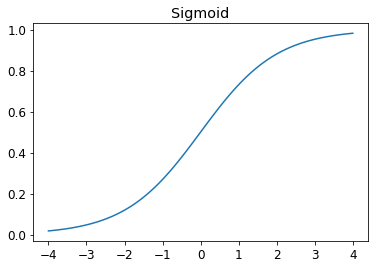

In [25]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

- As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. 


- It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients. 


- Let's update `mnist_loss` to first apply `sigmoid` to the inputs:

In [26]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

- Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. 
 
  All that is required is that a higher prediction corresponds to higher confidence an image is a 3.


- Having defined a loss function, now is a good moment to recapitulate why we did this. After all, we already had a metric, which was overall accuracy. So why did we define a loss?


- The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. 

  To drive automated learning, the loss must be a function that has a meaningful derivative. 
  
   It can't have big flat sections and large jumps, but instead must be reasonably smooth. 
   
   This is why we designed a loss function that would respond to small changes in confidence level. 
   
   This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal, and a function that can be optimized using its gradient. 
   
   The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.


- Metrics, on the other hand, are the numbers that we really care about. 

  These are the values that are printed at the end of each epoch that tell us how our model is really doing. 
  
  It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

<h3 align="center">SGD and Mini-Batch (Revisited)</h3>


Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an *optimization step*.

In order to take an optimization step we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset, and take the average, or we could calculate it for a single data item. But neither of these is ideal. Calculating it for the whole dataset would take a very long time. Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient. That is, you'd be going to the trouble of updating the weights, but taking into account only how that would improve the model's performance on that single item.

So instead we take a compromise between the two: we calculate the average loss for a few data items at a time. This is called a *mini-batch*. The number of data items in the mini-batch is called the *batch size*. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. We will talk about how to make this choice throughout this course.

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. These accelerators only perform well if they have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!

As we saw in our discussion of data augmentation in <<chapter_production>>, we get better generalization if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.

A `DataLoader` can take any Python collection and turn it into an iterator over many batches, like so:

In [27]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`. Here's an example of an extremely simple `Dataset`:

In [28]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

- When we pass a `Dataset` to a `DataLoader` we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables:

In [29]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

- We are now ready to write our first training loop for a model using SGD!

<h3 align="center">Putting All Together</h3>


- It's time to implement the process we saw in <<gradient_descent>>. In code, our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

- First, let's re-initialize our parameters:

In [30]:
weights = init_params((28*28,1))
bias = init_params(1)

- A `DataLoader` can be created from a `Dataset`:

In [31]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

- We'll do the same for the validation set:

In [32]:
valid_dl = DataLoader(valid_dset, batch_size=256)

- Let's create a mini-batch of size 4 for testing:

In [33]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [34]:
preds = linear1(batch)
preds

tensor([[11.6180],
        [ 9.0489],
        [-2.4524],
        [-2.5197]], grad_fn=<AddBackward0>)

In [35]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4616, grad_fn=<MeanBackward0>)

- Now we can calculate the gradients:

In [36]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0057), tensor([-0.0355]))

- Let's put that all in a function:

In [37]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

- and test it:

In [38]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0113), tensor([-0.0710]))

- But look what happens if we call it twice:

In [39]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0170), tensor([-0.1065]))

- The gradients have changed! The reason for this is that `loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [40]:
weights.grad.zero_()
bias.grad.zero_();

**Note**: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [41]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [42]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [False]])

That gives us this function to calculate our validation accuracy:

In [43]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

We can check it works:

In [44]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

and then put the batches together:

In [45]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [46]:
validate_epoch(linear1)

0.549

- That's our starting point. 


- Let's train for one epoch, and see if the accuracy improves:

In [47]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6294

- Then do a few more:

In [48]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8129 0.913 0.9443 0.956 0.9624 0.9668 0.9692 0.9707 0.9721 0.9741 0.9746 0.9751 0.976 0.9765 0.9765 0.977 0.9775 0.9775 0.9775 0.9775 

- Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. 


- Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an **optimizer**.

<h3 align="center">Creating an Optimizer</h3>

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

In [49]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [50]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [51]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can create our optimizer by passing in the model's parameters:

In [52]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [53]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Our validation function doesn't need to change at all:

In [54]:
validate_epoch(linear_model)

0.3567

Let's put our little training loop in a function, to make things simpler:

In [55]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

In [56]:
train_model(linear_model, 20)

0.4932 0.77 0.856 0.9175 0.9355 0.9492 0.9551 0.9634 0.9658 0.9682 0.9697 0.9726 0.9741 0.9746 0.9761 0.9761 0.9775 0.978 0.978 0.9785 

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

In [57]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8149 0.854 0.917 0.9351 0.9497 0.9555 0.9629 0.9658 0.9682 0.9697 0.9717 0.9746 0.9751 0.9761 0.977 0.978 0.978 0.9785 0.9785 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

In [58]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `cnn_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [59]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `fit`:

In [60]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636801,0.503659,0.495584,00:00
1,0.595294,0.167055,0.868008,00:00
2,0.216102,0.194360,0.820903,00:00
3,0.092935,0.109724,0.909715,00:00
4,0.047683,0.078979,0.932287,00:00
5,0.030144,0.062828,0.946025,00:00
6,0.023021,0.052928,0.955348,00:00
7,0.019919,0.046416,0.962218,00:00
8,0.018390,0.041868,0.965162,00:00
9,0.017501,0.038526,0.967615,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

<h3 align="center">Adding a Nonlinearity</h3>

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [61]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

In [62]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

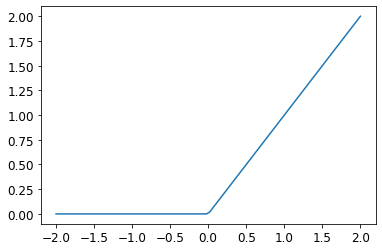

In [63]:
plot_function(F.relu)

> J: There is an enormous amount of jargon in deep learning, including terms like _rectified linear unit_. The vast vast majority of this jargon is no more complicated than can be implemented in a short line of code, as we saw in this example. The reality is that for academics to get their papers published they need to make them sound as impressive and sophisticated as possible. One of the ways that they do that is to introduce jargon. Unfortunately, this has the result that the field ends up becoming far more intimidating and difficult to get into than it should be. You do have to learn the jargon, because otherwise papers and tutorials are not going to mean much to you. But that doesn't mean you have to find the jargon intimidating. Just remember, when you come across a word or phrase that you haven't seen before, it will almost certainly turn out to be referring to a very simple concept.

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

> S: Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [64]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

In [65]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [66]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.319949,0.414147,0.504416,00:00
1,0.149887,0.226945,0.809127,00:00
2,0.082251,0.113654,0.916585,00:00
3,0.053631,0.077005,0.940628,00:00
4,0.040468,0.060260,0.957311,00:00
5,0.033788,0.050843,0.964181,00:00
6,0.029965,0.044894,0.966634,00:00
7,0.027485,0.040826,0.967615,00:00
8,0.025698,0.037871,0.968597,00:00
9,0.024315,0.035616,0.969578,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

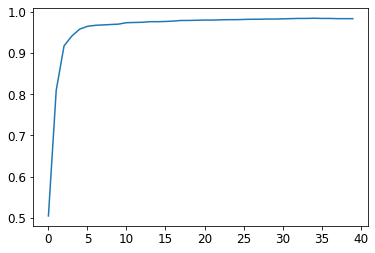

In [67]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

In [68]:
learn.recorder.values[-1][2]

0.982826292514801

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

<h3 align="center">Going Deeper</h3>

There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

That means that we can train the model more quickly, and it will take up less memory. In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity. This theoretical but not practical foundation held back the field for years. Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice. Eventually, theoretical results were developed which showed why this happens. Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

Here what happens when we train an 18-layer model using the same approach we saw in <<chapter_intro>>:

In [69]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: DataLoader worker (pid(s) 7824, 7536, 13132, 6320, 13792, 8224, 10500, 12632, 708, 8412, 9708, 13612, 8548, 2752, 624, 7848) exited unexpectedly

<h1 align="center">End of Seminar</h1>